Creating Multimodel RAG (Retrieval-Augmented-Generation)
What is RAG?
It is the process of optimizing the output of a large language model. RAG process references a knowledge base outside of its training data sources before generating a response.

Three main components of RAG

Ingestion
Retrieval
Generation
What is MultiModel RAG?
Multimodel RAG is AI system that can understand different modalities like images, audio, video and text. It enables AI systems to process and integrate data from numerous modalities, such as text, audio, video, tables etc.

There are three main ways to approach the multimodel RAG:

Option 1

Use multimodel embeddings to embed images.
Retrieve all using similarity search.
Pass raw images and text chunks to a multimodel LLM for an answer generation.
Option 2

Use a multimodel LLM to produce text summaries from images.
Embed all (summaries of images, tables and text) and retrieve text.
Pass text chunk to an LLM for answer generation.
Option 3

Use a multimodel LLM to produce text summaries from images.
Embed and retrieve image summaries with a reference to the raw image.
Pass the raw image and text chunk to a multimodal LLM for answer generation.


In [30]:
from dotenv import load_dotenv

load_dotenv()

True

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images,Tables etc.

Partition PDF Tables, Text and Images
If you didn't have poppler and tesseract installed and add it to Path

In [ ]:
from unstructured.partition.pdf import partition_pdf

output_path = './content/'
file_path = output_path + 'DietaryGuideliness.pdf'

def partition_and_chunk_pdf(file_path):
    """Partitions and chunks a PDF file into manageable pieces.
    """
    chunks= partition_pdf(
        filename=file_path,
        infer_tables_structure=True,          # Extract tables with structure
        strategy='hi_res',                     # Mandatory to infer tables

        extract_image_block_types=["Image"],   # Add 'Table' to list to extract tables as images
        # image_output_dir_path=output_path,    # Directory to save images

        extract_image_block_to_payload=True,   # Extract metadata element containing base64 object of the image
                                                # Must when sending the image to LLMs

        chunking_strategy="by_title",          # Chunking strategy to use, can be 'by_title', 'basic'
        max_characters=2000,                   # Maximum number of characters per chunk
        combine_text_under_n_chars=500,        # Combine text blocks under this number of characters with previous text block
        new_after_n_chars=6000,                # New chunk after this number of characters. Hard limit.
    )
    return chunks

/mnt/c/workspaces/langchain_pydantic/lang/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
file_path='/mnt/c/workspaces/langchain_pydantic/content/DietaryGuideliness.pdf'
chunks=partition_and_chunk_pdf(file_path)

Check all the Types in chunks we extracted from the PDF

In [7]:
a = set()
for chunk in chunks:
    for el in chunk.metadata.orig_elements:
        a.add(el.category)
print(a)

{'Header', 'Footer', 'FigureCaption', 'Table', 'NarrativeText', 'Image', 'ListItem', 'Title', 'UncategorizedText'}


In [8]:
def get_table(chunks):
    tables = []
    for chunk in chunks:
        for el in chunk.metadata.orig_elements:
            if 'Table' in str(type(el)):
                print(el.to_dict())
                tables.append(el)
    return tables

tables = get_table(chunks)

{'type': 'Table', 'element_id': 'ba3d9432-57f4-444f-9c78-197b232960a4', 'text': 'First Published —_...... Reprinted — ..., Second Edition _—e_...', 'metadata': {'detection_class_prob': 0.3188486695289612, 'coordinates': {'points': ((201.88238525390625, 218.69456481933594), (201.88238525390625, 316.837646484375), (593.6365966796875, 316.837646484375), (593.6365966796875, 218.69456481933594)), 'system': 'PixelSpace', 'layout_width': 1500, 'layout_height': 2000}, 'last_modified': '2025-06-09T10:03:30', 'filetype': 'PPM', 'languages': ['eng'], 'page_number': 3}}
{'type': 'Table', 'element_id': '4b1218de-ef88-453b-8ba0-6592e1ed9b94', 'text': 'CSIR Emeritus-Scientist Chancellor Bangalore Avinashalingam deemed University Coimbatore Dr. Bamji. Mahtab S. Dr. Ramachandran A. Former Director-Grade Scientist, NIN Diabetes research Centre ICMR Emeritus scientist Chennai Hyderabad Dr. Bhan MK. Dr. Rao MV Additional Professor Former Vice-Chancellor All India Institute of Medical Sciences A.P.Agricult

In [9]:
len(chunks)

170

Extract images from the Chunks

In [10]:
## getting the images from the CompositeElement object

def get_image_base64(chunks):
    image_b64 = []
    for chunk in chunks:
        chunk_el = chunk.metadata.orig_elements
        for el in chunk_el:
            if 'Image' in str(type(el)):
                image_b64.append(el.metadata.image_base64)
    return image_b64

images = get_image_base64(chunks)

Check the Image


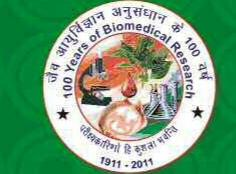

In [ ]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    ## decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # display the image
    display(Image(data=image_data))

display_base64_image(images[0])

Save the Text frpm the PDF

In [12]:
def save_texts(chunks):
    """
    Extracts texts from the list of chunks.
    """
    texts = [chunk for chunk in chunks if 'CompositeElement' in str(type(chunk))]

    return texts

In [13]:
texts = save_texts(chunks)

In [14]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser




In [15]:
## Summarizing Text

## Create a Groq model
model = ChatOpenAI(temperature=0.5, model='gpt-4o-mini')

## Create a prompt template for summarization
prompt = '''
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a summary" or anything similar.
just give the summary as it is.

Table or text chunk: {element}
'''

prompt_template = ChatPromptTemplate.from_template(prompt)

## chain the prompt with the Groq model and output parser
chain = prompt_template | model | StrOutputParser()

In [16]:
## Summarize text
text_summaries = chain.batch(texts,{"max_concurrency":3})

In [38]:
table_contents = [str(table) for table in tables]

# Then reuse the same chain to summarize tables
table_summaries = chain.batch(table_contents, {"max_concurrency": 3})

In [24]:
from openai._exceptions import RateLimitError
import time

# 1. Prompt Template stays the same
prompt_template_image = """Describe the image in detail. Be specific about the architecture, graphs, plots such as bar plot"""

# 2. Function to dynamically format messages per image
def build_message(image_b64):
    return [
        ("user", [
            {"type": "text", "text": prompt_template_image},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_b64}"}},
        ])
    ]

# 3. Chain builder for single image message
def build_chain(image_b64):
    prompt_image = ChatPromptTemplate.from_messages(build_message(image_b64))
    return prompt_image | model | StrOutputParser()

# 4. Retry-enabled batch processor
def process_images_with_retry(images, delay=2):
    results = []
    for idx, image in enumerate(images):
        success = False
        while not success:
            try:
                print(f"🔍 Processing image {idx + 1}/{len(images)}...")
                chain = build_chain(image)
                result = chain.invoke({})
                results.append(result)
                success = True
            except RateLimitError:
                print("⚠️ Rate limit hit. Waiting before retry...")
                time.sleep(delay)
    return results

In [25]:
image_summaries = process_images_with_retry(images)

🔍 Processing image 1/44...
🔍 Processing image 2/44...
🔍 Processing image 3/44...
🔍 Processing image 4/44...
🔍 Processing image 5/44...
🔍 Processing image 6/44...
🔍 Processing image 7/44...
🔍 Processing image 8/44...
🔍 Processing image 9/44...
🔍 Processing image 10/44...
🔍 Processing image 11/44...
🔍 Processing image 12/44...
🔍 Processing image 13/44...
🔍 Processing image 14/44...
🔍 Processing image 15/44...
🔍 Processing image 16/44...
🔍 Processing image 17/44...
🔍 Processing image 18/44...
🔍 Processing image 19/44...
🔍 Processing image 20/44...
🔍 Processing image 21/44...
🔍 Processing image 22/44...
🔍 Processing image 23/44...
🔍 Processing image 24/44...
🔍 Processing image 25/44...
🔍 Processing image 26/44...
🔍 Processing image 27/44...
🔍 Processing image 28/44...
🔍 Processing image 29/44...
🔍 Processing image 30/44...
🔍 Processing image 31/44...
🔍 Processing image 32/44...
🔍 Processing image 33/44...
🔍 Processing image 34/44...
🔍 Processing image 35/44...
🔍 Processing image 36/44...
🔍

In [40]:
table_summaries[20]

'The meal plan includes the following servings: \n\n- **Breakfast**: 100 ml milk, 15 g sugar, 2 cups of tea or 1 cup of coffee, 70 g cereals, and 20 g pulses.\n- **Lunch**: 120 g cereals, 2 cups of rice, 2 pulkas, 20 g pulses, 1/2 cup dhal, 150 g vegetables (curry), 50 g vegetables (salad), 100 ml milk, 1/2 cup curd, and 50 g cereals.\n- **Snack**: 50 ml milk, 1 cup tea, and 10 g sugar.\n- **Dinner**: 120 g cereals, 2 cups of rice, 2 pulkas, 20 g pulses, 1/2 cup dhal, 150 g vegetables (curry), 50 ml milk (curd), and 100 g seasonal fruit.'

In [26]:
print(image_summaries[0])

The image features a circular emblem set against a green background. At the center of the emblem, there are various symbols representing biomedical research. These include a laboratory flask, a plant, and a stylized depiction of a cell or tissue, along with a droplet of liquid, which likely symbolizes scientific experimentation and discovery.

Surrounding the central imagery, the emblem includes text in both Hindi and English. The Hindi text reads "जैव चिकित्सा अनुसंधान के 100 वर्ष," which translates to "100 Years of Biomedical Research." The English text reinforces this message with the same phrase. 

At the bottom of the emblem, there are dates marked "1911 - 2011," indicating the centennial celebration of biomedical research. Additionally, there are two stars on either side of the circular border, which adds a decorative element to the design. 

The overall design is clean and professional, suitable for a formal celebration or recognition of significant achievements in the field of 

In [27]:
import uuid
import os
from langchain_astradb import AstraDBVectorStore
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [31]:
token = os.getenv('ASTRA_DB_APPLICATION_TOKEN')
namespace = os.getenv('ASTRA_DB_KEYSPACE')
endpoint = os.getenv('ASTRA_DB_API_ENDPOINT')
embedding = OpenAIEmbeddings(model="text-embedding-3-large")

In [32]:
endpoint

'https://815caf9c-e985-4283-b634-73bba5ecbb66-us-east-2.apps.astra.datastax.com'

In [ ]:
vector_store = AstraDBVectorStore(
    embedding=embedding,
    collection_name="RAG",
    api_endpoint=endpoint,
    token=token,
    namespace=namespace,
)

## The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

## The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vector_store,
    docstore=store,
    id_key=id_key,
)

In [ ]:
def loading_summaries_to_vector_store(retriever, chunks, chunk_summary):
    """
        Generate ids for each chunk, create langchain document object for each summry chunk.
        Indexing the summary in vector store and document in docsotre.
    """
    ## generate unique id for each chunk
    doc_ids = [str(uuid.uuid4()) for _ in texts]
    ## Creating Langchain Document objects for each text_summary chunk
    summary_texts = [Document(page_content=summary,metadata={id_key:doc_ids[i]}) for i,summary in enumerate(chunk_summary)]

    ## indexing the documents in vector store and document store
    retriever.vectorstore.add_documents(summary_texts)
    retriever.docstore.mset(list(zip(doc_ids,chunks)))

In [ ]:
## adding text summaries to vector store and document store
loading_summaries_to_vector_store(retriever,texts,text_summaries)
## adding image summaries to vector store and document store
loading_summaries_to_vector_store(retriever,images,image_summaries)
## Now the retriever is ready to use


KeyboardInterrupt: 

In [42]:
loading_summaries_to_vector_store(retriever, tables, table_summaries)

In [ ]:
doc = retriever.invoke("")

for d in doc[0:1]:
    print(d)

Year: Month Months -3 SD 10: 1 121 12.8 10: 2 122 12.8 10: 3 123 12.8 10: 4 124 12.9 10: 5 125 12.9 10: 6 126 12.9 10: 7 127 12.9 10: 8 128 13.0 10: 9 129 13.0 10: 10 130 13.0 10: 11 131 13.0 11: 0 132 13.1 11: 1 133 13.1 11: 2 134 13.1 11: 3 135 13.1 11: 4 136 13.2 11: 5 137 13.2 11: 6 138 13.2 11: 7 139 13.2 11: 8 140 13.3 11: 9 141 13.3 11: 10 142 13.3 11: 11 143 13.4 12: 0 144 13.4 12: 1 145 13.4 12: 2 146 13.5 12: 3 147 13.5 12: 4 148 13.5 -2 SD 13.8 13.8 13.8 13.8 13.9 13.9 13.9 13.9 14.0 14.0 14.0 14.1 14.1 14.1 14.1 14.2 14.2 14.2 14.3 14.3 14.3 14.4 14.4 14.5 14.5 14.5 14.6 14.6 -1 SD 15.0 15.0 15.0 15.0 15.1 15.1 15.1 15.2 15.2 15.2 15.3 15.3 15.3 15.4 15.4 15.5 15.5 15.5 15.6 15.6 15.7 15.7 15.7 15.8 15.8 15.9 15.9 16.0 Median 16.5 16.5 16.6 16.6 16.6 16.7 16.7 16.8 16.8 16.9 16.9 16.9 17.0 17.0 17.1 17.1 17.2 17.2 17.3 17.3 17.4 17.4 17.5 17.5 17.6 17.6 17.7 17.8 1 SD 18.5 18.6 18.6 18.7 18.8 18.8 18.9 18.9 19.0 19.0 19.1 19.2 19.2 19.3 19.3 19.4 19.5 19.5 19.6 19.7 19.7 19

In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

from langchain_openai import ChatOpenAI
from base64 import b64decode
from langchain.prompts.chat import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

def parse_docs(docs):
    """Parses the retrieved documents into a context with text and images."""
    image_doc = []
    text_doc = []
    for doc in docs:
        try:
            b64decode(doc)
            image_doc.append(doc)
        except Exception:
            text_doc.append(doc)

    return {"images": image_doc, "text": [d.text for d in text_doc]}

# Define a ChatPromptTemplate directly
prompt = ChatPromptTemplate.from_template(
    """
    Answer the question based only on this context.

    Context:
    {context}

    Question:
    {question}
    """
)



model = ChatOpenAI(temperature=0.5, model='gpt-4o-mini')

# Combine into a pipeline
chain = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough()
} | prompt | model | StrOutputParser()

In [ ]:
question = "How much of physical exercise is needed?"
result = chain.invoke(question)

print("Response from LLM :", result)

Response from LLM : It is recommended to carry out at least 45 minutes of physical activity of moderate intensity for at least 5 days a week. To lose weight, experts recommend at least 60 minutes of moderate- to vigorous-intensity physical activity on most days of the week. Those on low-calorie diets for body weight reduction should engage in moderate to vigorous intensity physical activities for at least 60-90 minutes daily.


In [ ]:

question = "Recommended Dietary Allowances for Indian mens"
result = chain.invoke(question)

print("Response from LLM :", result)

Response from LLM : The Recommended Dietary Allowances (RDA) for Indian men based on their activity levels are as follows:

1. **Sedentary work**: 
   - Energy: 2320 Kcal/day 
   - Protein: 60 g/day 
   - Fat: 30 g/day 

2. **Moderate work**: 
   - Energy: 2730 Kcal/day 
   - Protein: 70 g/day 
   - Fat: 30 g/day 

3. **Heavy work**: 
   - Energy: 3490 Kcal/day 
   - Protein: 80 g/day 
   - Fat: 40 g/day 

These values provide guidance on the nutritional needs for Indian men based on their level of physical activity.


In [ ]:

question = "Balanced Diet for (Number of Portions) for boys 16 to 18 years of age"
result = chain.invoke(question)

print("Response from LLM :", result)

Response from LLM : For boys aged 16 to 18 years, the balanced diet (number of portions) is as follows:

- Millets: 15 g
- Pulses: 3 g
- Milk & milk products: 3 portions (100 ml each)
- Roots & tubers: 2 portions (100 g each)
- Green leafy vegetables: 1 portion (100 g)
- Other vegetables: 2 portions (100 g each)
- Fruits: 1 portion (100 g)
- Sugar: 9 g
- Fat: 6 g
